<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
CLUSTERS</p><br>

Para iniciar este apartado, nos preguntaremos si, para cada `usuario_id` es posible contestar:

- ¿Usa el sistema para trabajar?
- ¿Usa el sistema para estudiar?
- ¿Usa el sistema para pasear?

In [1]:
#funciones y clases particulares al caso de estudio
from localpacks.data import get_data, get_data_others, format_data, clean_garbage

#datasets
import numpy as np
import pandas as pd

#graficos
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GMM

## Importamos nuestro df

In [2]:
#funcion que transforma el tiempo de uso, en un time_delta
def convert_time(s):
    h, m, s = map(int, s.split(':'))
    return pd.Timedelta(hours=h, minutes=m, seconds=s)

In [3]:
df = pd.read_csv('./data/recorridos-realizados-2018.csv', converters={'bici_tiempo_uso':convert_time})

In [4]:
df['bici_tiempo_uso_seg'] = df['bici_tiempo_uso'].astype('int64') / 1E9 #para graficar facilmente con seaborn convertimos el timedelta a segundos

In [5]:
df.index = pd.to_datetime(df['bici_fecha_hora_retiro'], format='%Y-%m-%d %H:%M:%S') #1.Damos formato e indexamos
del df['bici_fecha_hora_retiro'] #Eliminamos la columna 'bici_fecha_hora_retiro'

In [6]:
df.head(5)

,id_usuario,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_tiempo_uso_seg
bici_fecha_hora_retiro,,,,,,,,,
2018-01-01 00:08:05,5453,00:19:53,Uruguay,45,Virrey Cevallos,183,M,45,1193.0
2018-01-01 00:18:05,673,00:26:19,Posadas,189,Guardia Vieja,110,M,61,1579.0
2018-01-01 00:20:14,179119,00:27:39,Hospital Rivadavia,50,Padilla,31,F,52,1659.0
2018-01-01 00:20:22,400147,00:48:51,Macacha Güemes,111,Acuña de Figueroa,54,M,27,2931.0
2018-01-01 00:20:31,400156,00:49:27,Macacha Güemes,111,Acuña de Figueroa,54,F,27,2967.0


# Analisis PCA

En este apartado reduciremos la dimencionalidad para poder ver graficamente los clusters

# Transformamos nuestro df para usarlo en sklearn

In [7]:
df['time_uso_sklearn'] = df.bici_tiempo_uso_seg.transform(lambda x: int(x)) # transformamos el timedelta en un integer

In [8]:
le = preprocessing.LabelEncoder() #convertimos la variable en 0 y 1
le.fit(df['bici_sexo'])
le.classes_

array(['F', 'M', 'N'], dtype=object)

In [9]:
df['bici_sexo-sklearn'] = le.transform(df['bici_sexo']) #aplicamos la transformacion

In [10]:
subset = ['id_usuario', 'time_uso_sklearn', 'bici_sexo-sklearn', 'bici_edad' ]

In [11]:
df[subset].head(3) #escogemos un subset de atributos

,id_usuario,time_uso_sklearn,bici_sexo-sklearn,bici_edad
bici_fecha_hora_retiro,,,,
2018-01-01 00:08:05,5453,1193,1,45
2018-01-01 00:18:05,673,1579,1,61
2018-01-01 00:20:14,179119,1659,0,52


In [12]:
scaler = preprocessing.StandardScaler().fit(df[subset]) #llevamos nuestros datos a la misma escala
scaler

C:\Users\USUARIO\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [13]:
df_scaled = scaler.transform(df[subset])

C:\Users\USUARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


# Pruebas

In [14]:
model = PCA(n_components=2) #definimos nuestro modelo

In [15]:
%time model.fit(df[subset]) #entrenamos nuestro modelo

Wall time: 2.56 s


PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [16]:
%time bici_2D = model.transform(df_scaled)

Wall time: 91.8 ms


In [17]:
from dask.distributed import Client
from sklearn.externals.joblib import parallel_backend

In [18]:
client = Client()  # Connect to a Dask Cluster

In [19]:
with parallel_backend('dask'):
    %time model.fit(df[subset])

Wall time: 2.46 s


In [20]:
with parallel_backend('dask'):
    %time bici_2D = model.transform(df_scaled)

Wall time: 97.7 ms


Wall time: 22.8 s


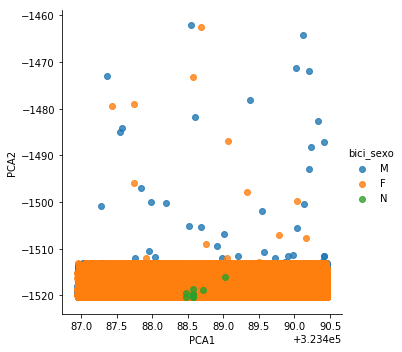

In [32]:
df['PCA1'] = bici_2D[:, 0]
df['PCA2'] = bici_2D[:, 1]
%time sns.lmplot("PCA1", "PCA2", hue='bici_sexo', data=df, fit_reg=False);

Wall time: 28.2 s


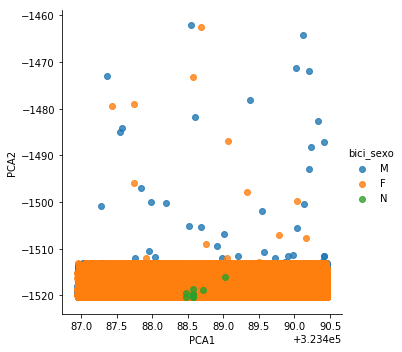

In [33]:
with parallel_backend('dask'):
    df['PCA1'] = bici_2D[:, 0]
    df['PCA2'] = bici_2D[:, 1]
    %time sns.lmplot("PCA1", "PCA2", hue='bici_sexo', data=df, fit_reg=False);

 # Gaussian mixture 

### Clusters = 3; Atendiendo a usuarios que trabajan, estudian, ocacionales.

In [ ]:
#modelos
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.mixture import GaussianMixture as GMM

In [ ]:
from dask_ml

In [22]:
#seleccionamos nuestro modelo para los generar los clusters
model = GMM(n_components=3, covariance_type='full') 

In [24]:
%time model.fit(df[subset]) 

Wall time: 1min 1s


GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [25]:
%time y_gmm = model.predict(df[subset])

Wall time: 1.15 s


In [26]:
with parallel_backend('dask'):
    %time model.fit(df[subset]) 

Wall time: 1min 2s


In [27]:
with parallel_backend('dask'):
    %time y_gmm = model.predict(df[subset])

Wall time: 1.34 s


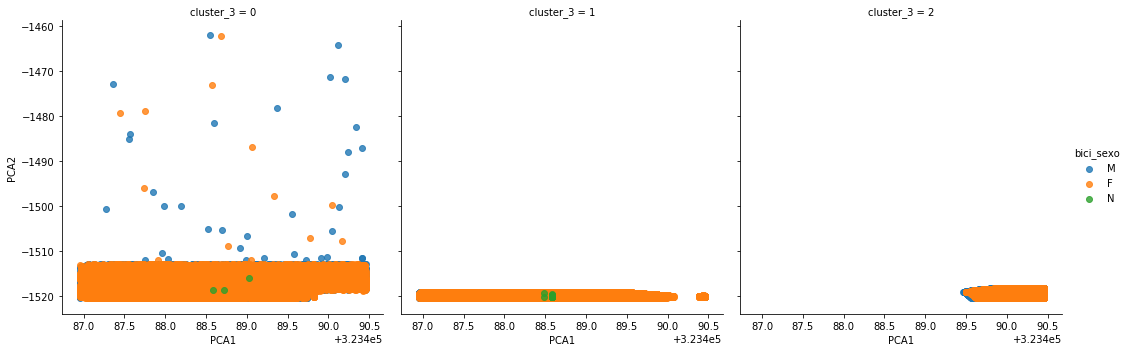

In [24]:
df['cluster_3'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=df, hue='bici_sexo', col='cluster_3', fit_reg=False);

Los cluster inicialmente planteados, al menos para el **bici_sexo** no presentan una diferencia clara.

### Clusters = 7; Atendiendo a las semanas

In [25]:
#seleccionamos nuestro modelo para los generar los clusters
model = GMM(n_components=7, covariance_type='full') 

df_aux =  df[subset][:100000]
model.fit(df_aux) 
y_gmm = model.predict(df_aux)

In [26]:
df_aux =  df[:100000]

C:\Users\USUARIO\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


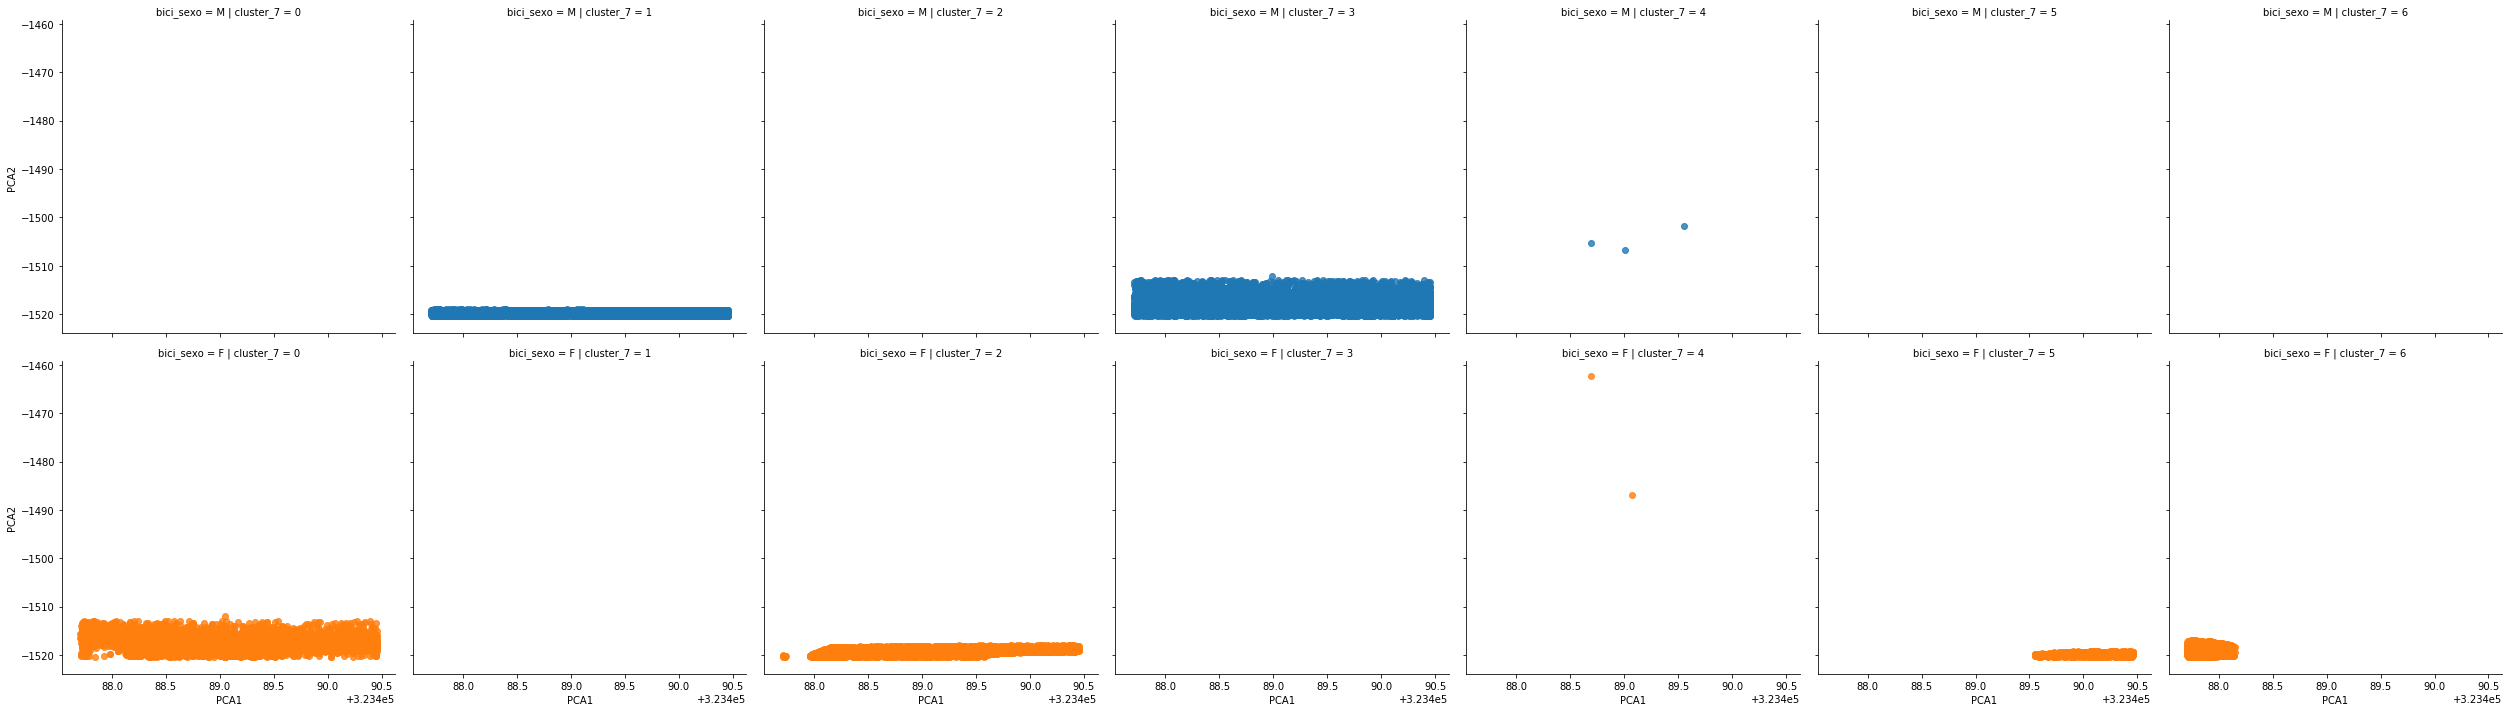

In [27]:
df_aux['cluster_7'] = y_gmm
sns.lmplot("PCA1", "PCA2", data=df_aux, hue='bici_sexo', row= 'bici_sexo', col='cluster_7', fit_reg=False);

In [28]:
df_aux.head(10)

,id_usuario,bici_tiempo_uso,bici_nombre_estacion_origen,bici_estacion_origen,bici_nombre_estacion_destino,bici_estacion_destino,bici_sexo,bici_edad,bici_tiempo_uso_seg,time_uso_sklearn,bici_sexo-sklearn,PCA1,PCA2,cluster_3,cluster_7
bici_fecha_hora_retiro,,,,,,,,,,,,,,,
2018-01-01 00:08:05,5453,00:19:53,Uruguay,45,Virrey Cevallos,183,M,45,1193.0,1193,1,323490.427925,-1519.728785,2,1
2018-01-01 00:18:05,673,00:26:19,Posadas,189,Guardia Vieja,110,M,61,1579.0,1579,1,323490.453899,-1519.455907,2,3
2018-01-01 00:20:14,179119,00:27:39,Hospital Rivadavia,50,Padilla,31,F,52,1659.0,1659,0,323489.482888,-1519.399765,0,0
2018-01-01 00:20:22,400147,00:48:51,Macacha Güemes,111,Acuña de Figueroa,54,M,27,2931.0,2931,1,323488.279979,-1518.502410,0,3
2018-01-01 00:20:31,400156,00:49:27,Macacha Güemes,111,Acuña de Figueroa,54,F,27,2967.0,2967,0,323488.279925,-1518.476955,0,2
2018-01-01 00:21:01,476733,00:36:10,Yatay,121,Billinghurst y Valentin Gomez,143,F,31,2170.0,2170,0,323487.863364,-1519.039713,0,6
2018-01-01 00:21:30,326932,00:35:31,Yatay,121,Billinghurst y Valentin Gomez,143,F,28,2131.0,2131,0,323488.678486,-1519.067142,0,2
2018-01-01 00:22:48,347609,00:31:07,Pque. Jose Evaristo Uriburu,155,Cerrito,71,M,26,1867.0,1867,1,323488.566011,-1519.253650,1,1
2018-01-01 00:23:46,392077,00:34:28,Obelisco,7,Azucena Villaflor,79,F,29,2068.0,2068,0,323488.324020,-1519.111679,0,2
